<a href="https://colab.research.google.com/github/tvkk1999/ML_Prac/blob/main/2_End_to_End_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The main steps in an end-to-end ML:
1. Figure out the problem statement
2. Gather the data
3. Explratory data analysis and visualization
4. Data preparation
5. Model selection and training
6. Fine-tuning the model
7. Solution presenation
8. Launch, monitor, and maintain your system.


# 1. The problem statement
- Your Task is to build a

###Notes
- A sequence of data processing components is called a data *_pipeline_*.
- The components in the data pipeline typically run asynchronously.
- Proper monitoring is needed to aviod unnoticed component failures.

## Loading the dataset

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def laod_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = laod_housing_data()

/tmp/ipython-input-2400801713.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


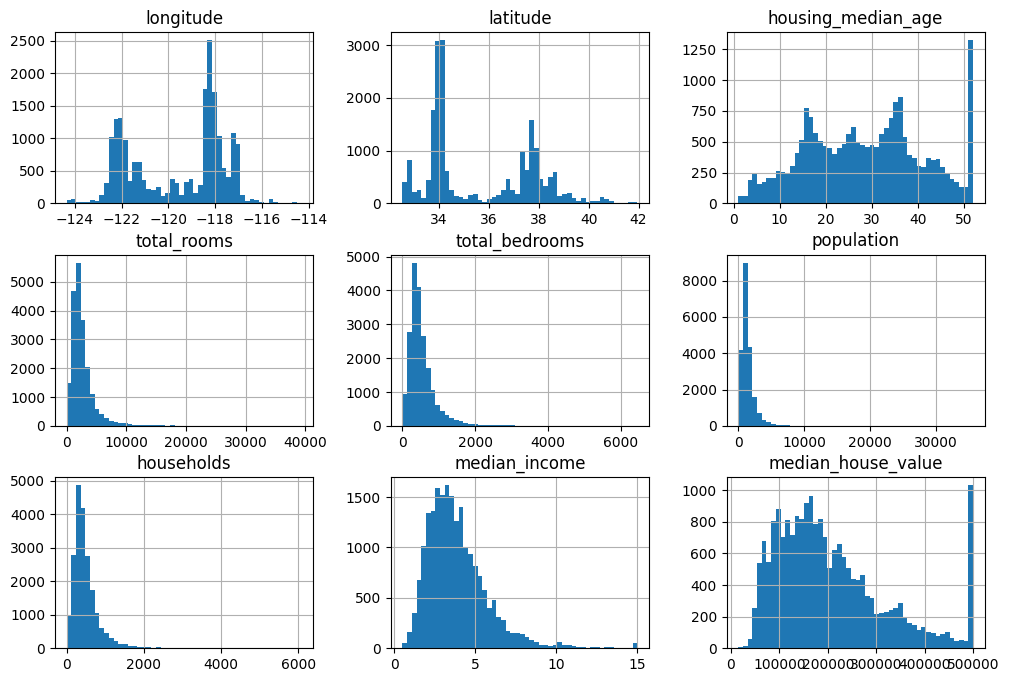

In [6]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [7]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  print(shuffled_indices)
  test_set_size = int(len(data) * test_ratio)
  print(test_set_size)
  test_indices = shuffled_indices[:test_set_size]
  print(test_indices)
  train_indices = shuffled_indices[test_set_size:]
  print(train_indices)
  return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

[ 3820  3612  5027 ...  9341 12133    35]
4128
[ 3820  3612  5027 ...  2860   400 18086]
[ 9486 13149 14363 ...  9341 12133    35]


In [9]:
len(train_set), len(test_set)

(16512, 4128)

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is `train_test_split()`, which does pretty much the same thing as the `shuffle_and_split_data()` function we defined earlier.

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [11]:
train_set, test_set

(       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 14196    -117.22     32.75                34.0       6001.0          1111.0   
 8267     -117.03     32.69                10.0        901.0           163.0   
 17445    -122.27     37.74                28.0       6909.0          1554.0   
 14265    -121.82     37.25                25.0       4021.0           634.0   
 2271     -115.98     33.32                 8.0        240.0            46.0   
 ...          ...       ...                 ...          ...             ...   
 11284    -122.37     37.94                49.0        969.0           229.0   
 11964    -118.38     33.89                35.0       1778.0           330.0   
 5390     -119.33     36.28                16.0       2624.0           527.0   
 860      -117.19     34.08                22.0       2467.0           555.0   
 15795    -118.86     34.22                22.0       1230.0           200.0   
 
        population  households  median

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

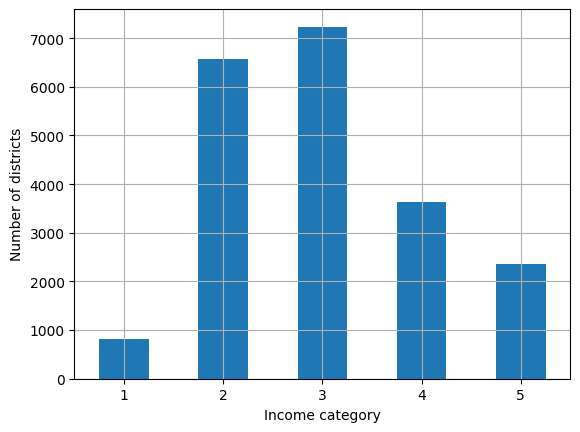

In [18]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
splitter

StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None)

In [28]:
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])
  # print(train_index, test_index)

In [25]:
strat_splits[:1]

[[       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
  13096    -122.42     37.80                52.0       3321.0          1115.0   
  14973    -118.38     34.14                40.0       1965.0           354.0   
  3785     -121.98     38.36                33.0       1083.0           217.0   
  14689    -117.11     33.75                17.0       4174.0           851.0   
  20507    -118.15     33.77                36.0       4366.0          1211.0   
  ...          ...       ...                 ...          ...             ...   
  14207    -118.40     33.86                41.0       2237.0           597.0   
  13105    -119.31     36.32                23.0       2945.0           592.0   
  19301    -117.06     32.59                13.0       3920.0           775.0   
  19121    -118.40     34.06                37.0       3781.0           873.0   
  19888    -122.41     37.66                44.0        431.0           195.0   
  
         population  hous

In [29]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [30]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [31]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [32]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

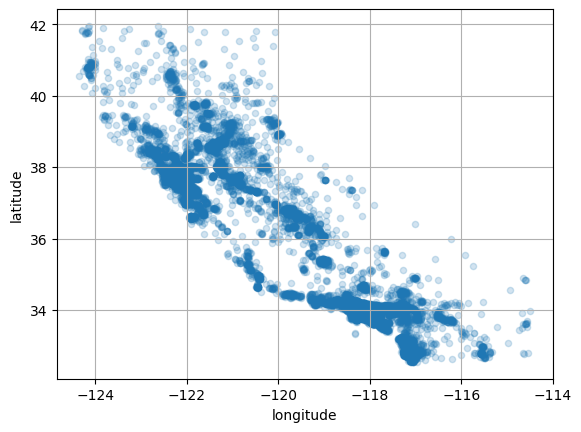

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

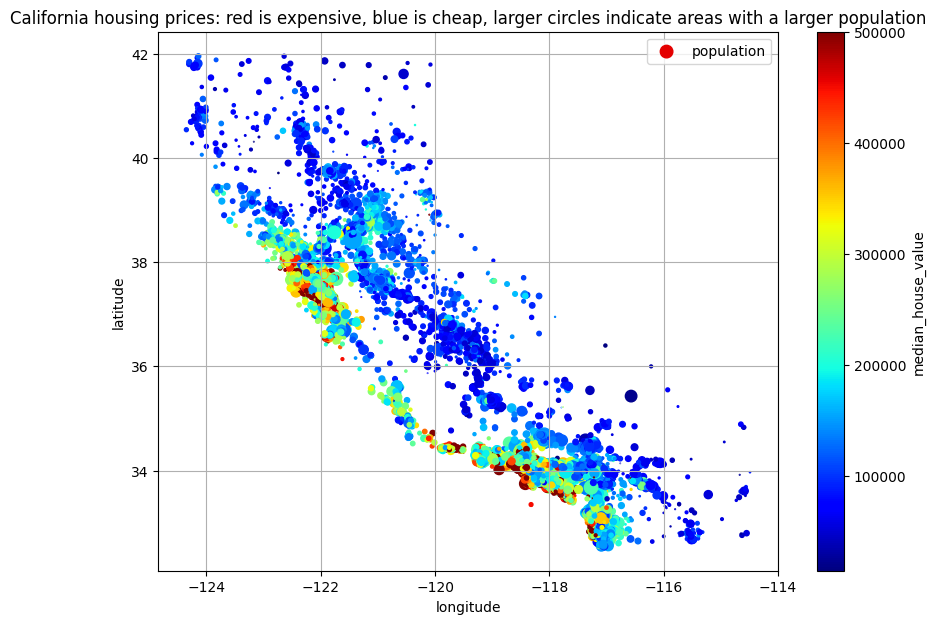

In [38]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10, 7))
plt.title("California housing prices: red is expensive, blue is cheap, larger circles indicate areas with a larger population")
plt.show()

### Look for Correlations

In [41]:
corr_matrix = housing.select_dtypes(include=['number']).corr()

In [43]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


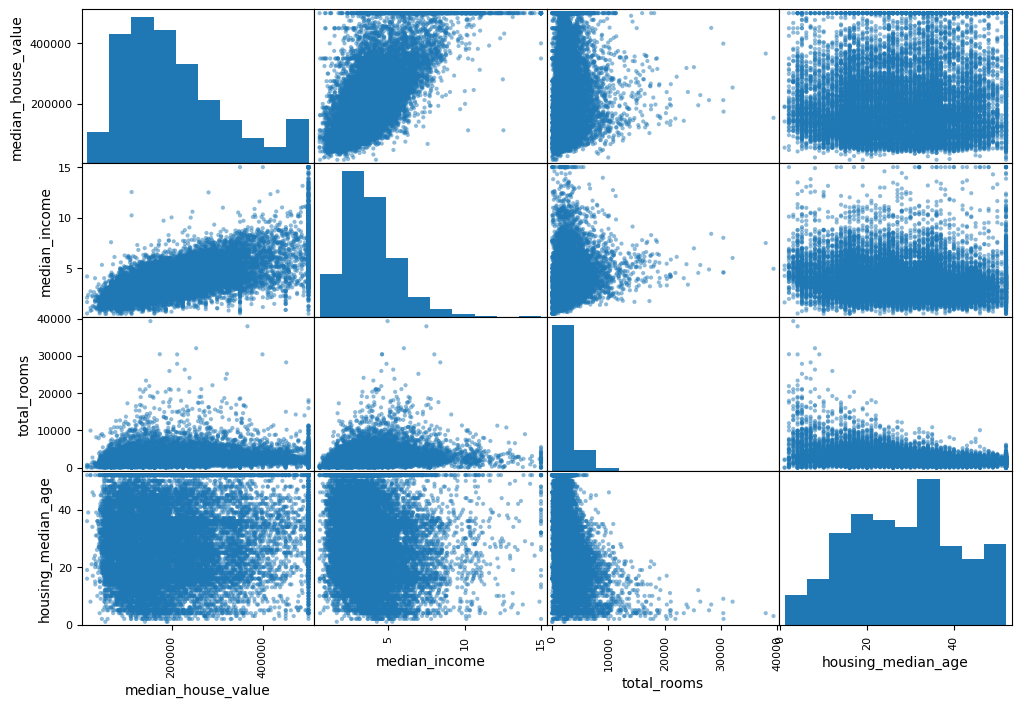

In [44]:
# scatter matrix - which plots every numerical attribute against every other numerical attribute.
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

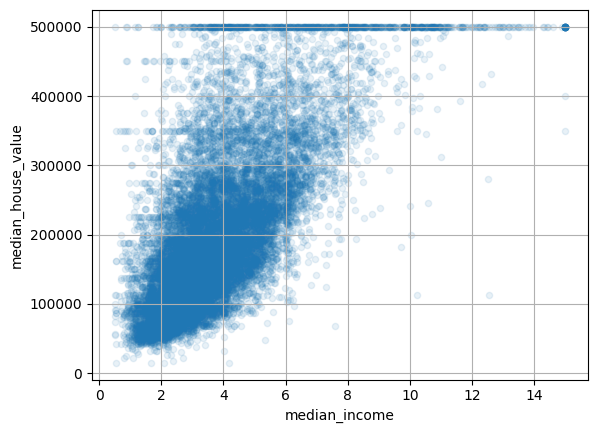

In [45]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

So far we have seen:
- Few data quirks that should be cleaned.
- Found interesting correlations between attributes, in particular with the target attribute.
- Some attributes have a skewed-right distribution, which should be transformed.

### Experiment with Attribute Combinations

For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household.

Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [46]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [50]:
corr_matrix = housing.select_dtypes(include=["number"]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
people_per_house,-0.038224
longitude,-0.050859


## Prepare the data for ML algos

In [52]:
# revert to a clean training set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Clean the data

Three options to fix missing values:
1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the missing values to some value (zero, the mean, the median, etc.). This is called *_imputation_*.

In [54]:
housing.dropna(subset=["total_bedrooms"], inplace=True) # option 1

housing.drop("total_bedrooms", axis=1) # option 2

median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median)

You decide to go for option 3 since it is the least destructive, but instead of the preceding code, you will use a handy Scikit-Learn class: `SimpleImputer`.

The benefit is that it will store the median value of each feature: this will make it possible to impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model.

In [58]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [59]:
# median can only be computed on numerical attributes, so invlude only numerical values

housing_num = housing.select_dtypes(include=[np.number])

In [60]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [61]:
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2125.5     434.     1167.      408.5
    3.5409]
[-118.51     34.26     29.     2125.5     434.     1167.      408.5
    3.5409]


In [62]:
X = imputer.transform(housing_num)

Missing values can also be replaced with the mean value (`strategy="mean"`), or with the most frequent value (`strategy="most_frequent"`), or with a constant value (`strategy="constant", fill_value=…`​). The last two strategies support non-numerical data.

There are also more powerful imputers available in the `sklearn.impute` package (both for numerical features only):

`KNNImputer` replaces each missing value with the mean of the k-nearest neighbors’ values for that feature. The distance is based on all the available features.

`IterativeImputer` trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several times, improving the models and the replacement values at each iteration.

Scikit-Learn transformers output NumPy arrays (or sometimes SciPy sparse matrices) even when they are fed Pandas DataFrames as input.⁠

In [63]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [64]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


## Handling text and Categorical Attributes

In [65]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [66]:
# ocean_proximity is a categorical attribute
# most ML algos prefer to work with numbers
# so convert these categories from text to numbers

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [67]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [68]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, and “excellent”), but it is obviously not the case for the `ocean_proximity` column.

 To fix this issue, a common solution is to create one binary attribute per category.

 This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

 The new attributes are sometimes called dummy attributes.

In [69]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)